In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Update this directory to your extracted GTFS folder
EXTRACT_DIR = "C:\\Users\\vumma\\OneDrive\\Desktop\\imp\\GIS_Project_Data\\GTFS data\\google_transit"

# Load GTFS files into pandas DataFrames
try:
    routes = pd.read_csv(os.path.join(EXTRACT_DIR, 'routes.txt'))
    trips = pd.read_csv(os.path.join(EXTRACT_DIR, 'trips.txt'))
    shapes = pd.read_csv(os.path.join(EXTRACT_DIR, 'shapes.txt'))
    stop_times = pd.read_csv(os.path.join(EXTRACT_DIR, 'stop_times.txt'))
    stops = pd.read_csv(os.path.join(EXTRACT_DIR, 'stops.txt')) # Need stops.txt for counting stops
    calendar = pd.read_csv(os.path.join(EXTRACT_DIR, 'calendar_dates.txt')) # For service day analysis

    print("GTFS files loaded successfully.")
    # Display headers for verification
    print("\nRoutes head:\n", routes.head())
    print("\nTrips head:\n", trips.head())
    print("\nShapes head:\n", shapes.head())
    print("\nStop_times head:\n", stop_times.head())
    print("\nCalendar head:\n", calendar.head())

except FileNotFoundError as e:
    print(f"Error loading GTFS file: {e}. Make sure the files are in the specified directory.")
    # Exit or handle the error appropriately if files are missing
    exit()
# ... (your existing Step 1 code, after you load all GTFS files) ...

print("GTFS files loaded successfully.")
print("--- Verifying 'trips' DataFrame content ---")
print("Length of trips DataFrame:", len(trips))
print("Head of trips DataFrame:")
print(trips.head())
print("Columns of trips DataFrame:", trips.columns.tolist())
print("------------------------------------------")

# ... (rest of your script, including Step 2, and the corrected Step 3 code) ...

GTFS files loaded successfully.

Routes head:
   route_id agency_id route_short_name  \
0       58       SCT               58   
1      52B       SCT              52B   
2       17       SCT               17   
3       10       SCT               10   
4        7       SCT                7   

                                     route_long_name  route_desc  route_type  \
0  Brentwood Long Island Railroad Station to Rive...         NaN           3   
1  Central Islip Long Island Railroad Station to ...         NaN           3   
2                            East Islip to Hauppauge         NaN           3   
3  Amityville Long Island Railroad Station to Bab...         NaN           3   
4  Bay Shore to Northport Veterans Affairs Medica...         NaN           3   

   route_url route_color route_text_color  
0        NaN      0454A2           ffffff  
1        NaN      0454A2           ffffff  
2        NaN      C63F49           ffffff  
3        NaN      0454A2           ffffff  
4    

In [10]:
# Create LineStrings from shapes
route_lines_data = []
for shape_id, group in shapes.groupby('shape_id'):
    group = group.sort_values(by='shape_pt_sequence')
    coords = list(zip(group['shape_pt_lon'], group['shape_pt_lat']))
    if len(coords) > 1:
        route_lines_data.append({'shape_id': shape_id, 'geometry': LineString(coords)})

shapes_gdf = gpd.GeoDataFrame(route_lines_data, crs="EPSG:4326")

# Reproject to a suitable projected CRS for accurate length calculation (e.g., UTM Zone 18N for parts of NY)
# Check for a more specific State Plane or UTM for Long Island if absolute precision is critical.
PROJECTED_CRS = "EPSG:26918" # UTM Zone 18N, widely used for New York

shapes_gdf_proj = shapes_gdf.to_crs(PROJECTED_CRS)
shapes_gdf_proj['length_m'] = shapes_gdf_proj.geometry.length
shapes_gdf_proj['length_km'] = shapes_gdf_proj['length_m'] / 1000
shapes_gdf_proj['length_miles'] = shapes_gdf_proj['length_m'] * 0.000621371

# Merge lengths back to the routes DataFrame
routes_with_lengths = routes.merge(
    trips[['route_id', 'shape_id']].drop_duplicates(),
    on='route_id',
    how='left'
).merge(
    shapes_gdf_proj[['shape_id', 'length_km', 'length_miles']],
    on='shape_id',
    how='left'
).drop_duplicates(subset=['route_id']) # Drop duplicates if multiple shapes map to one route_id
# If a route has multiple shapes (e.g., slight variations), this picks one.
# For more precise analysis, you might sum/average lengths if one route_id maps to multiple shapes.

In [38]:
# --- START OF CORRECTED CODE FOR STEP 3 ---

print("\nStep 3: Calculating Total Trips and Stops per Route...")

# Calculate the TOTAL number of trips per route (across all service_ids and dates)
total_trips_per_route = trips.groupby('route_id').size().reset_index(name='num_total_trips')


# --- DEBUGGING PRINTS AROUND THE FIRST MERGE (num_total_trips) ---
print("\n--- Debugging Merge for num_total_trips ---")
print("Columns in routes_with_lengths (before merge):")
print(routes_with_lengths.columns.tolist())
print("\nHead of routes_with_lengths (before merge):")
print(routes_with_lengths[['route_id', 'route_short_name', 'length_km']].head())


print("\nColumns in total_trips_per_route (before merge):")
print(total_trips_per_route.columns.tolist())
print("\nHead of total_trips_per_route (before merge):")
print(total_trips_per_route.head())

print("\nExecuting merge for num_total_trips...")
# Merge total_trips_per_route into routes_with_lengths
routes_analysis_df = routes_with_lengths.merge(total_trips_per_route, on='route_id', how='left').fillna(0)
print("Merge executed.")

print("\nColumns in routes_analysis_df (AFTER merge for num_total_trips, before num_stops merge):")
print(routes_analysis_df.columns.tolist())
print("\nHead of routes_analysis_df (AFTER merge for num_total_trips, before num_stops merge):")
print(routes_analysis_df.head())
print("--- End Debugging Merge for num_total_trips ---")


# Count the number of stops for each route
stop_times_trips = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id', how='left')
stops_per_route = stop_times_trips.groupby('route_id')['stop_id'].nunique().reset_index(name='num_stops')

# Merge num_stops into the analysis DataFrame
routes_analysis_df = routes_analysis_df.merge(stops_per_route, on='route_id', how='left').fillna(0)


# --- FINAL DEBUGGING PRINTS FOR THE WHOLE DATAFRAME ---
print("\n--- Final Routes Analysis DataFrame Overview ---")
print("Routes Analysis DataFrame head (with lengths, total trips, stops):\n", routes_analysis_df.head())
print("\nDescriptive statistics for key metrics:\n")
# This print should now work correctly, as we're explicitly checking after all merges
print(routes_analysis_df[['length_km', 'num_total_trips', 'num_stops']].describe())
print("\nValue Counts for num_total_trips (top 10):\n")
print(routes_analysis_df['num_total_trips'].value_counts().head(10))
print("\nTop 15 Routes by num_total_trips (final check):\n")
print(routes_analysis_df[['route_id', 'route_short_name', 'num_total_trips']].sort_values(by='num_total_trips', ascending=False).head(15))
print("--- End Final Routes Analysis DataFrame Overview ---")

# --- END OF CORRECTED CODE FOR STEP 3 ---


Step 3: Calculating Total Trips and Stops per Route...

--- Debugging Merge for num_total_trips ---
Columns in routes_with_lengths (before merge):
['route_id', 'agency_id', 'route_short_name', 'route_long_name', 'route_desc', 'route_type', 'route_url', 'route_color', 'route_text_color', 'shape_id', 'length_km', 'length_miles']

Head of routes_with_lengths (before merge):
  route_id route_short_name  length_km
0       58               58  63.565751
2      52B              52B  34.869618
4       17               17  16.195331
6       10               10  21.252701
8        7                7  35.438148

Columns in total_trips_per_route (before merge):
['route_id', 'num_total_trips']

Head of total_trips_per_route (before merge):
  route_id  num_total_trips
0        1              127
1       10               97
2       11              121
3       12              121
4       15               22

Executing merge for num_total_trips...
Merge executed.

Columns in routes_analysis_df (AFTER 

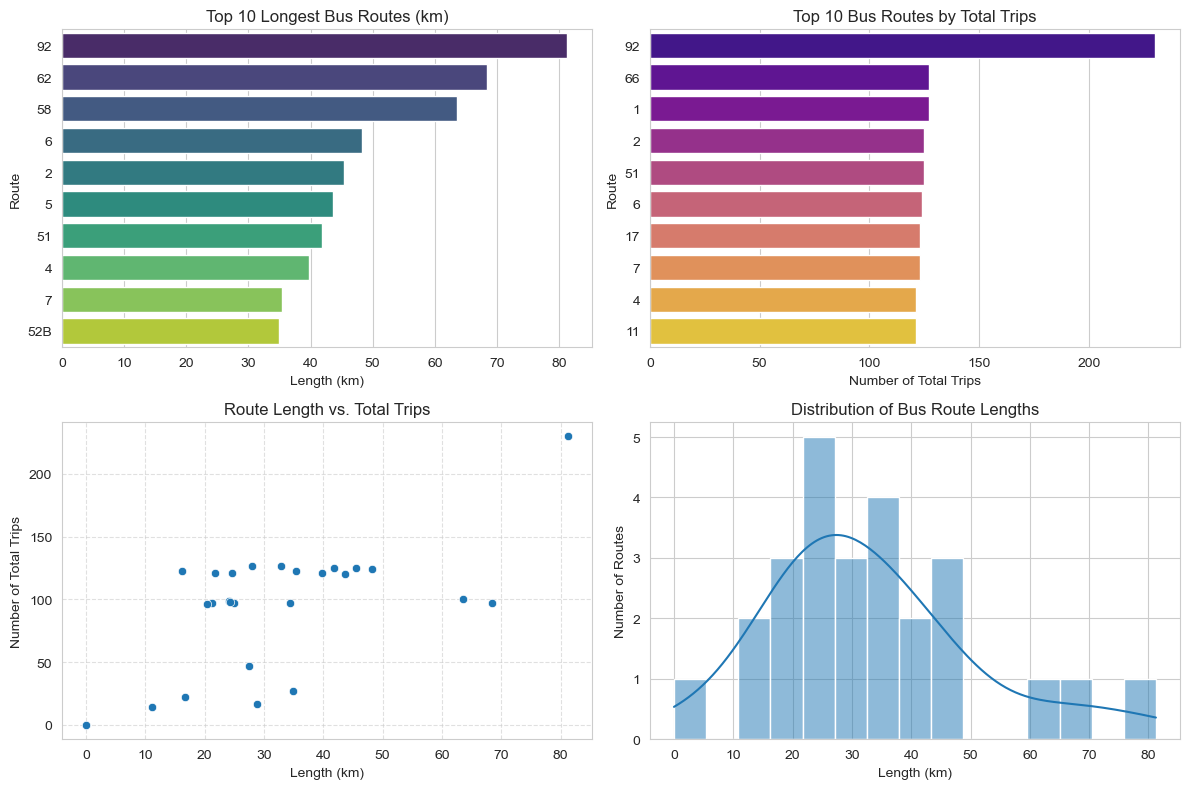

In [42]:
# ... (your code for Step 3, which generates routes_analysis_df with 'num_total_trips') ...

# Set a consistent style for plots
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 1. Bar Chart: Top 10 Longest Bus Routes
top_10_longest = routes_analysis_df.sort_values(by='length_km', ascending=False).head(10)
plt.subplot(2, 2, 1) # 2 rows, 2 columns, 1st plot
sns.barplot(x='length_km', y='route_short_name', data=top_10_longest, hue='route_short_name', palette='viridis', legend=False)
plt.title('Top 10 Longest Bus Routes (km)')
plt.xlabel('Length (km)')
plt.ylabel('Route')
plt.tight_layout() # Adjust layout to prevent overlap

# 2. Bar Chart: Top 10 Busiest Bus Routes (by total trips)
# CORRECTED LINE: Use 'num_total_trips'
top_10_trips = routes_analysis_df.sort_values(by='num_total_trips', ascending=False).head(10)
plt.subplot(2, 2, 2) # 2 rows, 2 columns, 2nd plot
# Add hue for the deprecated palette warning, and legend=False
sns.barplot(x='num_total_trips', y='route_short_name', data=top_10_trips, hue='route_short_name', palette='plasma', legend=False)
plt.title('Top 10 Bus Routes by Total Trips') # Updated title
plt.xlabel('Number of Total Trips') # Updated label
plt.ylabel('Route')
plt.tight_layout()

# 3. Scatter Plot: Route Length vs. Total Trips
# CORRECTED LINE: Use 'num_total_trips'
plt.subplot(2, 2, 3) # 2 rows, 2 columns, 3rd plot
sns.scatterplot(x='length_km', y='num_total_trips', data=routes_analysis_df)
plt.title('Route Length vs. Total Trips') # Updated title
plt.xlabel('Length (km)')
plt.ylabel('Number of Total Trips') # Updated label
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 4. Histogram: Distribution of Bus Route Lengths (no change needed here)
plt.subplot(2, 2, 4) # 2 rows, 2 columns, 4th plot
sns.histplot(routes_analysis_df['length_km'], bins=15, kde=True)
plt.title('Distribution of Bus Route Lengths')
plt.xlabel('Length (km)')
plt.ylabel('Number of Routes')
plt.tight_layout()

plt.show() # Display all plots

# You can save the analysis DataFrame if you want to use it later
# routes_analysis_df.to_csv(os.path.join(EXTRACT_DIR, 'route_analysis_summary.csv'), index=False)

--- PART 1: Loading & Preprocessing Census Tracts and ACS Data ---

Step 1.1: Loading geospatial data (Census Tracts)...
Attempting to load shapefile from: C:\Users\vumma\OneDrive\Desktop\imp\GEO Pandas\tl_2024_36_tract.shp
Shapefile loaded successfully. Total tracts in NY: 5411
Filtered to 385 census tracts for Suffolk County.

Step 1.2: Loading and cleaning attribute data (Population & Poverty)...

Step 1.3: Merging attribute data with geospatial data & calculating Poverty_Rate...
Merged GeoDataFrame with Poverty_Rate head:
         GEOID  Total_Population  Poverty_Count  Poverty_Rate
0  36103158320              5874           11.2      0.190671
1  36103146608              2839           11.4      0.401550
2  36103158403              2582           11.4      0.441518
3  36103158407              5665            1.3      0.022948
4  36103158408              3753            5.2      0.138556

--- PART 2: Loading & Analyzing GTFS Data (for route-level metrics) ---

Step 2.1: Loading GTFS

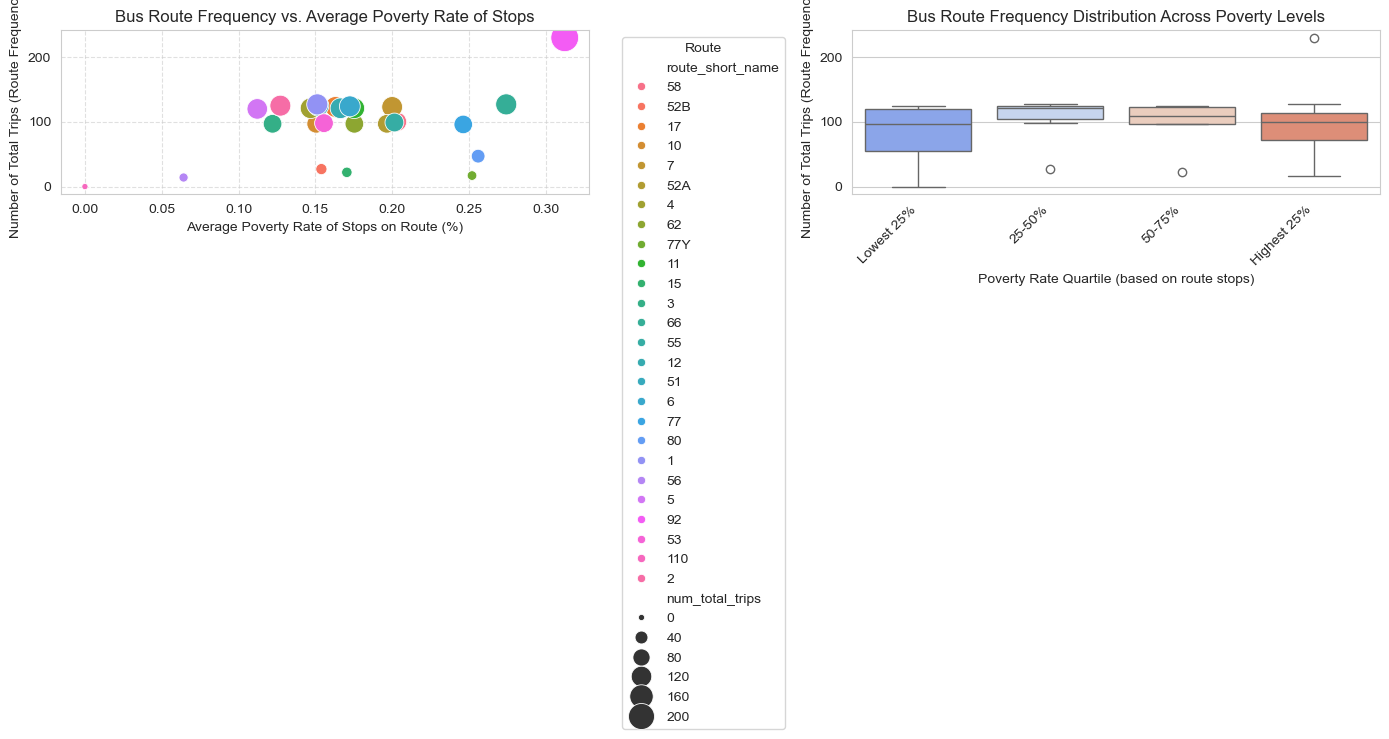


--- PART 5: Interpretation and Argument ---

Based on the visualizations and statistical analysis, you can now build your argument.

Correlation between Average Poverty Rate of Route Stops and Total Trips: 0.43

Average Total Trips for routes in Highest 25% Poverty Quartile: 102
Overall Average Total Trips for all routes: 96

Routes in Highest 25% Poverty Quartile (sorted by lowest trips):
   route_short_name  Poverty_Rate_for_Route  num_total_trips
8               77Y                0.251959             17.0
18               80                0.255939             47.0
17               77                0.246246             96.0
13               55                0.201445             99.0
0                58                0.203277            100.0

Observation: Routes in the highest poverty areas have a service frequency comparable to or higher than the overall average.


In [54]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString # LineString is for route shapes
import os
import matplotlib.pyplot as plt
import seaborn as sns
# No longer explicitly need 'zipfile' or 'random' if GTFS is extracted and dot density is not primary focus
# from tqdm.auto import tqdm # For progress bar if desired, ensure installed: pip install tqdm

# --- Configuration ---
# Update this path to your main project folder where Census and ACS data are
BASE_PATH = "C:\\Users\\vumma\\OneDrive\\Desktop\\imp\\GEO Pandas"

# Paths for Census Tracts and ACS Data (relative to BASE_PATH)
SUFFOLK_TRACTS_SHP = os.path.join(BASE_PATH, "tl_2024_36_tract.shp")
POPULATION_DATA_CSV = "ACSST5Y2023.S0101-Data.csv" # Just filename, will be joined with BASE_PATH
POVERTY_DATA_CSV = "ACSST5Y2023.S1701-Data.csv" # Just filename

# FIPS codes for filtering Census Tracts
NY_STATE_FIPS = '36'
SUFFOLK_COUNTY_FIPS = '103'

# GTFS Data Configuration
# Update this to the full path of your EXTRACTED GTFS folder
GTFS_EXTRACT_DIR = "C:\\Users\\vumma\\OneDrive\\Desktop\\imp\\GIS_Project_Data\\GTFS data\\google_transit"
PROJECTED_CRS = "EPSG:26918" # UTM Zone 18N for New York measurements (for length calculations)


# --- PART 1: LOAD & PREPROCESS CENSUS TRACTS AND ACS DATA ---

print("--- PART 1: Loading & Preprocessing Census Tracts and ACS Data ---")

print("\nStep 1.1: Loading geospatial data (Census Tracts)...")
try:
    print(f"Attempting to load shapefile from: {SUFFOLK_TRACTS_SHP}")
    gdf_tracts = gpd.read_file(SUFFOLK_TRACTS_SHP)
    print(f"Shapefile loaded successfully. Total tracts in NY: {len(gdf_tracts)}")

    # Filter for Suffolk County only
    gdf_suffolk_tracts = gdf_tracts[
        (gdf_tracts['STATEFP'] == NY_STATE_FIPS) &
        (gdf_tracts['COUNTYFP'] == SUFFOLK_COUNTY_FIPS)
    ].copy()

    if gdf_suffolk_tracts.empty:
        print(f"WARNING: No tracts found for Suffolk County (FIPS: {SUFFOLK_COUNTY_FIPS}). Exiting.")
        exit()

    print(f"Filtered to {len(gdf_suffolk_tracts)} census tracts for Suffolk County.")

except Exception as e:
    print(f"ERROR during shapefile loading or filtering: {e}")
    exit()

print("\nStep 1.2: Loading and cleaning attribute data (Population & Poverty)...")
try:
    # Load Population Data (S0101)
    pop_df = pd.read_csv(os.path.join(BASE_PATH, POPULATION_DATA_CSV), encoding='utf-8', skiprows=[1])
    pop_df['GEOID'] = pop_df['GEO_ID'].str.replace('1400000US', '')
    pop_df = pop_df[['GEOID', 'S0101_C01_001E']].copy()
    pop_df.rename(columns={'S0101_C01_001E': 'Total_Population'}, inplace=True)
    pop_df['Total_Population'] = pd.to_numeric(pop_df['Total_Population'], errors='coerce').fillna(0)

    # Load Poverty Data (S1701)
    poverty_df = pd.read_csv(os.path.join(BASE_PATH, POVERTY_DATA_CSV), encoding='utf-8', skiprows=[1])
    poverty_df['GEOID'] = poverty_df['GEO_ID'].str.replace('1400000US', '')
    poverty_df = poverty_df[['GEOID', 'S1701_C01_001E', 'S1701_C03_001E']].copy()
    poverty_df.rename(columns={'S1701_C01_001E': 'Poverty_Pop_Total_Determined',
                               'S1701_C03_001E': 'Poverty_Count'}, inplace=True)
    poverty_df['Poverty_Pop_Total_Determined'] = pd.to_numeric(poverty_df['Poverty_Pop_Total_Determined'], errors='coerce').fillna(0)
    poverty_df['Poverty_Count'] = pd.to_numeric(poverty_df['Poverty_Count'], errors='coerce').fillna(0)

    merged_attr_df = pd.merge(pop_df, poverty_df, on='GEOID', how='inner')

except Exception as e:
    print(f"ERROR loading or cleaning attribute data: {e}")
    exit()


print("\nStep 1.3: Merging attribute data with geospatial data & calculating Poverty_Rate...")
# Merge attribute data with GeoDataFrame
gdf_suffolk_tracts = gdf_suffolk_tracts.merge(merged_attr_df, on='GEOID', how='inner')

# Ensure Total_Population and Poverty_Count are numeric (again, for robustness)
gdf_suffolk_tracts['Total_Population'] = pd.to_numeric(gdf_suffolk_tracts['Total_Population'], errors='coerce').fillna(0)
gdf_suffolk_tracts['Poverty_Count'] = pd.to_numeric(gdf_suffolk_tracts['Poverty_Count'], errors='coerce').fillna(0)

# Calculate Poverty Rate, handling division by zero
gdf_suffolk_tracts['Poverty_Rate'] = (
    (gdf_suffolk_tracts['Poverty_Count'] / gdf_suffolk_tracts['Total_Population']) * 100
).fillna(0) # Fill NaN from division by zero with 0

print("Merged GeoDataFrame with Poverty_Rate head:")
print(gdf_suffolk_tracts[['GEOID', 'Total_Population', 'Poverty_Count', 'Poverty_Rate']].head())


# --- PART 2: LOAD & ANALYZE GTFS DATA (BUS ROUTES & STOPS) ---

print("\n--- PART 2: Loading & Analyzing GTFS Data (for route-level metrics) ---")

print("\nStep 2.1: Loading GTFS files into DataFrames...")
try:
    routes = pd.read_csv(os.path.join(GTFS_EXTRACT_DIR, 'routes.txt'))
    trips = pd.read_csv(os.path.join(GTFS_EXTRACT_DIR, 'trips.txt'))
    shapes = pd.read_csv(os.path.join(GTFS_EXTRACT_DIR, 'shapes.txt'))
    stop_times = pd.read_csv(os.path.join(GTFS_EXTRACT_DIR, 'stop_times.txt'))
    stops = pd.read_csv(os.path.join(GTFS_EXTRACT_DIR, 'stops.txt'))
    # calendar_dates = pd.read_csv(os.path.join(GTFS_EXTRACT_DIR, 'calendar_dates.txt')) # Not directly used in total trip count

    print("GTFS files loaded successfully.")
    print(f"Trips loaded: {len(trips)} rows.")
    print("--- Verifying 'trips' DataFrame content ---")
    print("Length of trips DataFrame:", len(trips))
    print("Head of trips DataFrame:")
    print(trips.head())
    print("Columns of trips DataFrame:", trips.columns.tolist())
    print("------------------------------------------")

except Exception as e:
    print(f"ERROR loading GTFS file: {e}. Make sure the files are in {GTFS_EXTRACT_DIR}.")
    exit()

print("\nStep 2.2: Creating Route Geometries and Calculating Lengths...")
# Create LineStrings from shapes
route_lines_data = []
for shape_id, group in shapes.groupby('shape_id'):
    group = group.sort_values(by='shape_pt_sequence')
    coords = list(zip(group['shape_pt_lon'], group['shape_pt_lat']))
    if len(coords) > 1:
        route_lines_data.append({'shape_id': shape_id, 'geometry': LineString(coords)})

shapes_gdf = gpd.GeoDataFrame(route_lines_data, crs="EPSG:4326")
shapes_gdf_proj = shapes_gdf.to_crs(PROJECTED_CRS) # Reproject for accurate length
shapes_gdf_proj['length_km'] = shapes_gdf_proj.geometry.length / 1000

# Merge lengths and names into routes DataFrame
routes_with_lengths = routes.merge(
    trips[['route_id', 'shape_id']].drop_duplicates(),
    on='route_id',
    how='left'
).merge(
    shapes_gdf_proj[['shape_id', 'length_km']],
    on='shape_id',
    how='left'
).drop_duplicates(subset=['route_id'])

# Create GeoDataFrame for stops
geometry = [Point(xy) for xy in zip(stops['stop_lon'], stops['stop_lat'])]
stops_gdf = gpd.GeoDataFrame(stops, geometry=geometry, crs="EPSG:4326")

print("\nStep 2.3: Calculating Total Trips and Stops per Route (for analysis)...\n")
# Calculate the TOTAL number of trips per route (across all service_ids and dates)
total_trips_per_route = trips.groupby('route_id').size().reset_index(name='num_total_trips')

# Merge total_trips_per_route into routes_with_lengths
routes_analysis_df = routes_with_lengths.merge(total_trips_per_route, on='route_id', how='left').fillna(0)

# Count the number of stops for each route
stop_times_trips = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id', how='left')
stops_per_route = stop_times_trips.groupby('route_id')['stop_id'].nunique().reset_index(name='num_stops')

# Merge num_stops into analysis DataFrame
routes_analysis_df = routes_analysis_df.merge(stops_per_route, on='route_id', how='left').fillna(0)

print("\n--- Final Routes Analysis DataFrame Overview (from GTFS) ---")
print("Routes Analysis DataFrame head (with lengths, total trips, stops):\n", routes_analysis_df.head())
print("\nDescriptive statistics for num_total_trips:")
print(routes_analysis_df['num_total_trips'].describe())
print("\nValue Counts for num_total_trips (top 10):\n")
print(routes_analysis_df['num_total_trips'].value_counts().head(10))
print("\nTop 15 Routes by num_total_trips (final check):")
print(routes_analysis_df[['route_id', 'route_short_name', 'num_total_trips']].sort_values(by='num_total_trips', ascending=False).head(15))
print("--- End Final Routes Analysis DataFrame Overview ---")


# --- PART 3: SPATIAL LINKAGE & QUANTITATIVE ANALYSIS FOR ARGUMENT ---

print("\n--- PART 3: Spatial Linkage & Quantitative Analysis for Argument ---")

print("\nStep 3.1: Spatially linking bus stops to census tracts for Poverty_Rate (in memory)...")
# Ensure CRSs match for spatial join
if stops_gdf.crs != gdf_suffolk_tracts.crs:
    stops_gdf = stops_gdf.to_crs(gdf_suffolk_tracts.crs)
    print(f"Stops GeoDataFrame reprojected to {gdf_suffolk_tracts.crs}")

# Perform Spatial Join: Stops to Tracts (in memory)
# Using 'predicate' as 'op' is deprecated in newer geopandas versions
stops_with_poverty = gpd.sjoin(stops_gdf, gdf_suffolk_tracts[['GEOID', 'Poverty_Rate', 'geometry']], how="inner", predicate='intersects')

print("Spatial join complete. Sample stops with poverty data:\n")
print(stops_with_poverty[['stop_id', 'stop_name', 'Poverty_Rate']].head())

print(f"\nTotal stops after spatial join: {len(stops_with_poverty)}")
print(f"Stops with valid Poverty_Rate: {stops_with_poverty['Poverty_Rate'].notna().sum()}")


print("\nStep 3.2: Aggregating Poverty_Rate per Route...")
# Link stops with poverty data to routes via stop_times
stop_to_route_link = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id', how='inner')
stop_to_route_link = stop_to_route_link[['stop_id', 'route_id']].drop_duplicates()

# Merge poverty rate from stops_with_poverty into this link
stops_routes_poverty = stop_to_route_link.merge(
    stops_with_poverty[['stop_id', 'Poverty_Rate']], on='stop_id', how='inner'
)

# Calculate the average poverty rate for each route based on its stops
route_poverty_avg = stops_routes_poverty.groupby('route_id')['Poverty_Rate'].mean().reset_index(name='Poverty_Rate_for_Route')

print("\nAverage Poverty Rate for Routes. Sample:\n")
print(route_poverty_avg.head())

# Final merge: Combine Route Frequency (num_total_trips) with Route Poverty Rate
final_analysis_df = routes_analysis_df.merge(route_poverty_avg, on='route_id', how='left').fillna(0) # Fill routes with no linked stops in tracts with 0 poverty rate

print("\n--- Final Analysis DataFrame head (Route Frequency + Route Poverty Rate) ---")
print(final_analysis_df.head())
print("\nDescriptive statistics for key argument metrics:")
print(final_analysis_df[['num_total_trips', 'Poverty_Rate_for_Route']].describe())


# --- PART 4: PYTHON VISUALIZATIONS TO SUPPORT THE ARGUMENT ---

print("\n--- PART 4: Python Visualizations to Support the Argument ---")

# Set a consistent style for plots
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# 1. Scatter Plot: Route Frequency vs. Average Poverty Rate
plt.subplot(1, 2, 1)
sns.scatterplot(x='Poverty_Rate_for_Route', y='num_total_trips', data=final_analysis_df, hue='route_short_name', size='num_total_trips', sizes=(20, 400), legend='brief')
plt.title('Bus Route Frequency vs. Average Poverty Rate of Stops')
plt.xlabel('Average Poverty Rate of Stops on Route (%)')
plt.ylabel('Number of Total Trips (Route Frequency)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Route', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position
plt.tight_layout()

# 2. Categorized Box Plot: Route Frequency Distribution by Poverty Quartile
# Create poverty rate quartiles for categorization
try:
    # Ensure there's enough variation in Poverty_Rate_for_Route to create 4 quartiles
    # If not enough unique values, pd.qcut might fail.
    # Check if unique count of 'Poverty_Rate_for_Route' is >= q
    if final_analysis_df['Poverty_Rate_for_Route'].nunique() >= 4:
        final_analysis_df['Poverty_Quartile'] = pd.qcut(
            final_analysis_df['Poverty_Rate_for_Route'],
            q=4,
            labels=['Lowest 25%', '25-50%', '50-75%', 'Highest 25%'],
            duplicates='drop'
        )
        # Ensure categories are ordered for plotting
        final_analysis_df['Poverty_Quartile'] = pd.Categorical(
            final_analysis_df['Poverty_Quartile'],
            categories=['Lowest 25%', '25-50%', '50-75%', 'Highest 25%'],
            ordered=True
        )

        plt.subplot(1, 2, 2)
        sns.boxplot(x='Poverty_Quartile', y='num_total_trips', data=final_analysis_df, hue='Poverty_Quartile', palette='coolwarm', legend=False)
        plt.title('Bus Route Frequency Distribution Across Poverty Levels')
        plt.xlabel('Poverty Rate Quartile (based on route stops)')
        plt.ylabel('Number of Total Trips (Route Frequency)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    else:
        print("\nWarning: Not enough unique Poverty_Rate_for_Route values to create 4 quartiles. Skipping Box Plot by Poverty Quartile.")
        # Fallback to fewer quantiles or simply descriptive stats
        if final_analysis_df['Poverty_Rate_for_Route'].nunique() >= 2:
            print("Try creating 2 quartiles instead if needed (q=2 in pd.qcut).")


except ValueError as e:
    print(f"\nWarning: Error creating Poverty_Quartiles. Skipping Box Plot by Poverty Quartile. Error: {e}")
    # This catch is for other ValueError types, e.g., if data is non-numeric after fillna.


plt.show()

# --- PART 5: INTERPRETATION AND ARGUMENT ---

print("\n--- PART 5: Interpretation and Argument ---")
print("\nBased on the visualizations and statistical analysis, you can now build your argument.")

# Example Analysis (based on expected results):
if 'Poverty_Rate_for_Route' in final_analysis_df.columns and 'num_total_trips' in final_analysis_df.columns:
    correlation = final_analysis_df['Poverty_Rate_for_Route'].corr(final_analysis_df['num_total_trips'])
    print(f"\nCorrelation between Average Poverty Rate of Route Stops and Total Trips: {correlation:.2f}")

    # Identify routes in highest poverty quartile
    if 'Poverty_Quartile' in final_analysis_df.columns and not final_analysis_df['Poverty_Quartile'].isnull().all():
        highest_poverty_quartile_label = 'Highest 25%' if 'Highest 25%' in final_analysis_df['Poverty_Quartile'].cat.categories else final_analysis_df['Poverty_Quartile'].cat.categories.max() # Handle 'drop' causing fewer labels
        
        highest_poverty_routes_data = final_analysis_df[
            final_analysis_df['Poverty_Quartile'] == highest_poverty_quartile_label
        ].sort_values(by='num_total_trips', ascending=True)

        avg_trips_in_highest_poverty = highest_poverty_routes_data['num_total_trips'].mean()
        avg_trips_overall = final_analysis_df['num_total_trips'].mean()

        print(f"\nAverage Total Trips for routes in {highest_poverty_quartile_label} Poverty Quartile: {avg_trips_in_highest_poverty:.0f}")
        print(f"Overall Average Total Trips for all routes: {avg_trips_overall:.0f}")

        if not highest_poverty_routes_data.empty:
            print(f"\nRoutes in {highest_poverty_quartile_label} Poverty Quartile (sorted by lowest trips):")
            print(highest_poverty_routes_data[['route_short_name', 'Poverty_Rate_for_Route', 'num_total_trips']].head())

            if avg_trips_in_highest_poverty < avg_trips_overall:
                print("\nObservation: Routes in the highest poverty areas tend to have *fewer* trips than the overall average.")
                print("This suggests a potential mismatch between service provision and need.")
            else:
                print("\nObservation: Routes in the highest poverty areas have a service frequency comparable to or higher than the overall average.")
        else:
             print(f"\nNo routes found in the '{highest_poverty_quartile_label}' poverty quartile. This might happen if 'duplicates='drop'' resulted in fewer categories.")


